<a href="https://colab.research.google.com/github/manuhola/viajes/blob/main/Diagrama_Ts_Linde_y_Claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

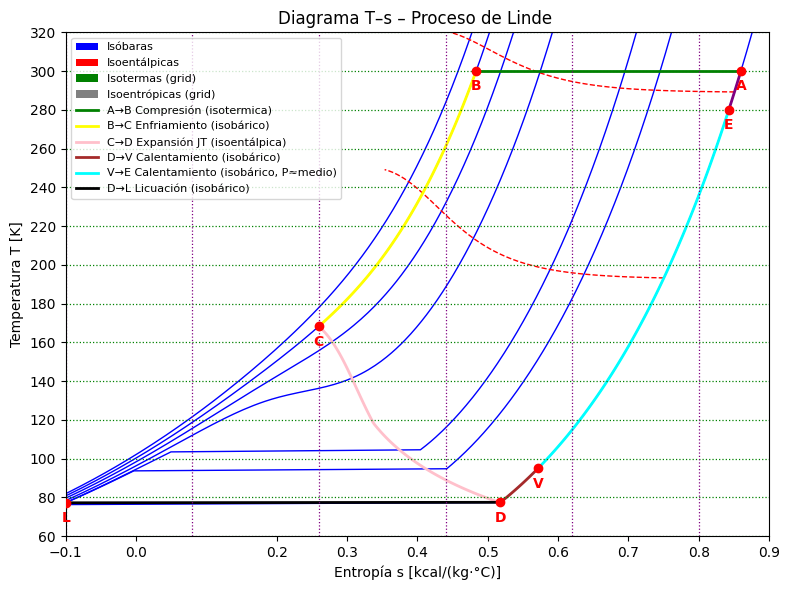

Presión para B: 36.1 bar


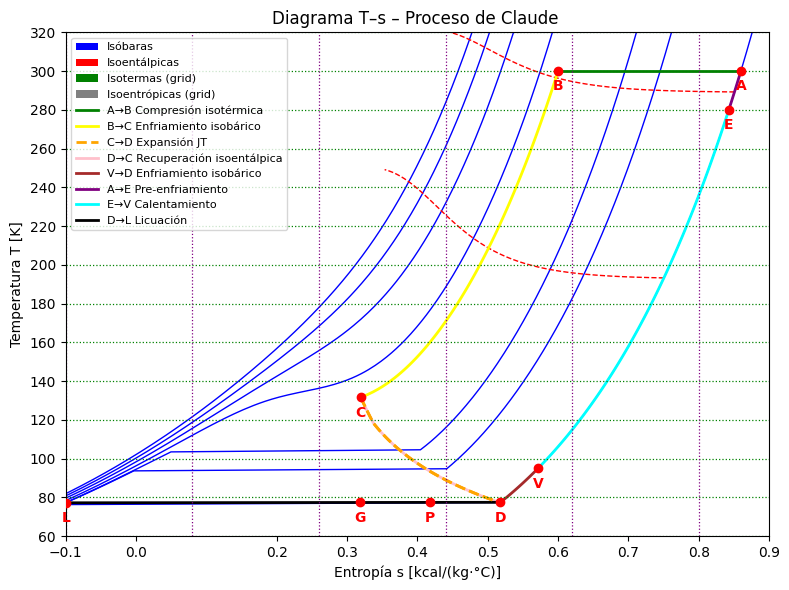

In [35]:

!pip install matplotlib CoolProp
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ========= Config general =========
fluid = "Nitrogen"
P_low, P_mid, P_high = 1e5, 5e5, 150e5
T_range = (60, 320)     # Para familias
isobars_bar = [1, 5, 10, 50, 100, 150, 200]
h_list = [2.0e5, 3.0e5, 4.0e5]      # J/kg para isoentálpicas
TARGET_A_S = 0.86                   # Ubicación horizontal deseada de A (kcal/kg°C)

# --- Conversión y offset para que s caiga en [-0.1,0.9] como el libro ---
def s_to_kcal_perkgC(s_J_perkgK):   # J/(kg·K) -> kcal/(kg·°C)
    return s_J_perkgK / 4184.0

# offset se calcula con el estado A a 300 K y 1 bar
sA_real = PropsSI("S","T",300,"P",P_low,fluid)      # J/(kg·K)
S_OFFSET = TARGET_A_S - s_to_kcal_perkgC(sA_real)   # kcal/(kg·°C)

def s_plot_from_real(s_J_perkgK):
    """Convierte a kcal/(kg·°C) y aplica offset para reproducir el eje del libro."""
    return s_to_kcal_perkgC(s_J_perkgK) + S_OFFSET

# ========= Familias de curvas =========
def plot_families():
    T = np.linspace(*T_range, 240)

    # Isóbaras (azul)
    for pbar in isobars_bar:
        P = pbar*1e5
        S_vals, T_vals = [], []
        for Ti in T:
            try:
                sJ = PropsSI("S","T",Ti,"P",P,fluid)
                S_vals.append(s_plot_from_real(sJ))
                T_vals.append(Ti)
            except:
                S_vals.append(np.nan); T_vals.append(np.nan)
        plt.plot(S_vals, T_vals, color="blue", lw=1)

    # Isoentálpicas (rojo punteado): barrido en P
    P_range = np.logspace(5, 7.5, 80)  # 1 bar a ~300 bar
    for h in h_list:
        S_vals, T_vals = [], []
        for Pi in P_range:
            try:
                Ti = PropsSI("T","P",Pi,"H",h,fluid)
                sJ = PropsSI("S","P",Pi,"H",h,fluid)
                S_vals.append(s_plot_from_real(sJ))
                T_vals.append(Ti)
            except:
                S_vals.append(np.nan); T_vals.append(np.nan)
        plt.plot(S_vals, T_vals, ls="--", color="red", lw=1)

def custom_grid():
    # Cuadrícula: isotermas (horizontales) e isoentrópicas (verticales)
    plt.grid(False)
    for Tiso in range(60, 321, 20):
        plt.axhline(y=Tiso, color="green", ls=":", lw=0.9)
    for siso in [-0.1, 0.08, 0.26, 0.44, 0.62, 0.80]:
        plt.axvline(x=siso, color="purple", ls=":", lw=0.9)

def apply_axes_and_legend(legend_handles, title):
    # Escalas iguales a tu figura
    plt.xlim(-0.1, 0.9)
    plt.ylim(60, 320)
    plt.xticks([-0.1, 0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    plt.yticks(np.arange(60, 321, 20))
    # Leyenda arriba-izquierda
    families = [
        Patch(facecolor='blue', label='Isóbaras'),
        Patch(facecolor='red',  label='Isoentálpicas'),
        Patch(facecolor='green',label='Isotermas (grid)'),
        Patch(facecolor='grey', label='Isoentrópicas (grid)'),
    ]
    plt.legend(handles=families + legend_handles, loc="upper left", fontsize=8)
    plt.xlabel("Entropía s [kcal/(kg·°C)]")
    plt.ylabel("Temperatura T [K]")
    plt.title(title)
    plt.tight_layout()

# ========= Trazos de procesos (usando propiedades reales; el desplazamiento solo se aplica al graficar) =========
def path_isentropic(s_real_const, P1, P2, n=80, color="k", **kw):
    Ps = np.logspace(np.log10(P1), np.log10(P2), n)
    S,T = [],[]
    for Pi in Ps:
        try:
            Ti = PropsSI("T","P",Pi,"S",s_real_const,fluid)
            S.append(s_plot_from_real(s_real_const)); T.append(Ti)
        except:
            S.append(np.nan); T.append(np.nan)
    plt.plot(S, T, color=color, **kw)

def path_isobaric(P, T1, T2, n=120, color="k", **kw):
    Ts = np.linspace(T1, T2, n)
    S=[]
    for Ti in Ts:
        try:
            sJ = PropsSI("S","T",Ti,"P",P,fluid)
            S.append(s_plot_from_real(sJ))
        except:
            S.append(np.nan)
    plt.plot(S, Ts, color=color, **kw)

def path_isoenthalpic(h_const, P1, P2, n=120, color="k", **kw):
    Ps = np.logspace(np.log10(P1), np.log10(P2), n)
    S,T=[],[]
    for Pi in Ps:
        try:
            Ti = PropsSI("T","P",Pi,"H",h_const,fluid)
            sJ = PropsSI("S","P",Pi,"H",h_const,fluid)
            S.append(s_plot_from_real(sJ)); T.append(Ti)
        except:
            S.append(np.nan); T.append(np.nan)
    plt.plot(S, T, color=color, **kw)

def path_isothermal(T_const, P1, P2, n=120, color="k", **kw):
    """Trayectoria a temperatura constante entre dos presiones"""
    Ps = np.logspace(np.log10(P1), np.log10(P2), n)
    S, T = [], []
    for Pi in Ps:
        try:
            sJ = PropsSI("S","T",T_const,"P",Pi,fluid)
            S.append(s_plot_from_real(sJ))
            T.append(T_const)  # Temperatura constante
        except:
            S.append(np.nan)
            T.append(np.nan)
    plt.plot(S, T, color=color, **kw)
    return S, T

def mark_point(label, T, P=None, sJ=None, color="red"):
    """Marca un punto dado por (T,P) o por sJ (J/kgK) y T. Retorna (s_plot, T)."""
    if sJ is None:
        sJ = PropsSI("S","T",T,"P",P,fluid)
    s_plot = s_plot_from_real(sJ)
    plt.scatter(s_plot, T, color=color, zorder=5)
    plt.text(s_plot, T-10, label, ha="center", color=color, fontweight="bold")
    return (s_plot, T), sJ


# ========= 1) LINDE =========
plt.figure(figsize=(8,6))
plot_families()

# Puntos principales y procesos
(A, sA) = mark_point("A", 300, P=P_low)
(B, sB) = mark_point("B", 300, P=P_high)
(E, sE) = mark_point("E", 280, P=P_low)
h_E = PropsSI("H","T",E[1],"P",P_high,fluid)
# JT hasta ~95 K @ 1 bar
(V, sV) = mark_point("V", 95, P=P_low)
# Separador/gas frío a 85 K @ 1 bar
(D, sD) = mark_point("D", 77.5, P=P_low)
# C debe estar en la misma isobara que B (alta presión) y conectarse a D por isoentalpica
# Primero encontramos la entalpía de D
h_D = PropsSI("H","T",D[1],"P",P_low,fluid)

# Ahora encontramos la temperatura en la isobara alta que tiene la misma entalpía
T_C = PropsSI("T","P",P_high,"H",h_D,fluid)
(C, sC) = mark_point("C", T_C, P=P_high)

# Líquido saturado a 1 bar
T_L = PropsSI("T","P",P_low,"Q",0,fluid); sL_J = PropsSI("S","P",P_low,"Q",0,fluid)
(L, sL) = mark_point("L", T_L, sJ=sL_J)

# Conexiones con la familia correcta
path_isothermal(300, P_low, P_high, color="green", lw=2)         # A→B
path_isoenthalpic(h_D, P_low, P_high, color="pink", lw=2)        # c→D
path_isobaric(P_low, V[1], D[1], color="brown", lw=2)            # V→D
path_isobaric(P_low, A[1], E[1], color="purple", lw=2)           # E→A
path_isobaric(P_high, B[1], C[1], color="yellow", lw=2)          # B→C
plt.plot([D[0],L[0]],[D[1],L[1]], color="black", lw=2)           # D→L
path_isobaric(P_low, E[1], V[1], color="cyan", lw=2)             # V→E

legend_linde = [
    Line2D([0],[0], color="green",  lw=2, label="A→B Compresión (isotermica)"),
    Line2D([0],[0], color="yellow", lw=2, label="B→C Enfriamiento (isobárico)"),
    Line2D([0],[0], color="pink",   lw=2, label="C→D Expansión JT (isoentálpica)"),
    Line2D([0],[0], color="brown",   lw=2, label="D→V Calentamiento (isobárico)"),
    Line2D([0],[0], color="cyan",   lw=2, label="V→E Calentamiento (isobárico, P≈medio)"),
    Line2D([0],[0], color="black",  lw=2, label="D→L Licuación (isobárico)"),
]
custom_grid(); apply_axes_and_legend(legend_linde, "Diagrama T–s – Proceso de Linde ")
plt.show()

# ========= 2) CLAUDE =========
plt.figure(figsize=(8,6))
plot_families()

# Calculamos la entropía real que corresponde a 0.6 kcal/kg°C en la gráfica
s_deseada_grafica = 0.6
s_deseada_real_J = (s_deseada_grafica - S_OFFSET) * 4184.0

# Encontramos la presión que da T=300K y s=s_deseada_real_J
try:
    P_B = PropsSI("P", "T", 300, "S", s_deseada_real_J, fluid)
    print(f"Presión para B: {P_B/1e5:.1f} bar")
except:
    print("No se pudo encontrar presión para los valores dados")
    P_B = P_high


# Definimos los puntos
(A, sA) = mark_point("A", 300, P=P_low)
(B, sB) = mark_point("B", 300, P=P_B)
(E, sE) = mark_point("E", 280, P=P_low)
h_E = PropsSI("H","T",E[1],"P",P_B,fluid)

(V, sV) = mark_point("V", 95, P=P_low)

(D, sD) = mark_point("D", 77.5, P=P_low)


P = (sD_plot - s_shift, T_D)
sD_plot = D[0]
T_D = D[1]
s_shift = 0.1

plt.scatter(sD_plot - s_shift, T_D, color="red", zorder=6)
plt.text(sD_plot - s_shift, T_D - 10, "P", ha="center", color="red", fontweight="bold")

G = (sD_plot - s_shift, T_D)
sD_plot = D[0]
T_D = D[1]
s_shift = 0.2

plt.scatter(sD_plot - s_shift, T_D, color="red", zorder=6)
plt.text(sD_plot - s_shift, T_D - 10, "G", ha="center", color="red", fontweight="bold")

h_D = PropsSI("H","T",D[1],"P",P_low,fluid)
T_C = PropsSI("T","P",P_B,"H",h_D,fluid)
(C, sC) = mark_point("C", T_C, P=P_B)

T_L = PropsSI("T","P",P_low,"Q",0,fluid)
sL_J = PropsSI("S","P",P_low,"Q",0,fluid)
(L, sL) = mark_point("L", T_L, sJ=sL_J)

# Conexiones
path_isothermal(300, P_low, P_B, color="green", lw=2)
path_isoenthalpic(h_D, P_low, P_B, color="pink", lw=2)
path_isobaric(P_low, V[1], D[1], color="brown", lw=2)
path_isobaric(P_low, A[1], E[1], color="purple", lw=2)
path_isobaric(P_B, B[1], C[1], color="yellow", lw=2)
plt.plot([D[0],L[0]],[D[1],L[1]], color="black", lw=2)
path_isobaric(P_low, E[1], V[1], color="cyan", lw=2)


h_C = PropsSI("H","T",C[1],"P",P_B,fluid)
path_isoenthalpic(h_C, P_B, P_low, color="orange", lw=2, ls="--")


# Conexión adicional: expansión JT desde C hasta la presión baja
h_C = PropsSI("H","T",C[1],"P",P_B,fluid)
path_isoenthalpic(h_C, P_B, P_low, color="orange", lw=2, ls="--")  # C→? JT

legend_linde = [
    Line2D([0],[0], color="green",  lw=2, label="A→B Compresión isotérmica"),
    Line2D([0],[0], color="yellow", lw=2, label="B→C Enfriamiento isobárico"),
    Line2D([0],[0], color="orange", lw=2, ls="--", label="C→D Expansión JT"),
    Line2D([0],[0], color="pink",   lw=2, label="D→C Recuperación isoentálpica"),
    Line2D([0],[0], color="brown",  lw=2, label="V→D Enfriamiento isobárico"),
    Line2D([0],[0], color="purple", lw=2, label="A→E Pre-enfriamiento"),
    Line2D([0],[0], color="cyan",   lw=2, label="E→V Calentamiento"),
    Line2D([0],[0], color="black",  lw=2, label="D→L Licuación"),
]
custom_grid(); apply_axes_and_legend(legend_linde, "Diagrama T–s – Proceso de Claude ")
plt.show()

